# Mining TripAdvisor users opinions about restaurants

#### In this section of the project, it will be extracted the sentiments of the reviews for each restaurant, using Natural Language Processing (NLP) tools for Python.

## Part 1: Extracting the text data

In order to perform a sentiment analysis in any text data it is necessary to have this text data in an appropriate form.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pymongo

import time
import datetime as dt
%matplotlib inline

In [2]:
# Oppening the MongoDB Altas Connection
f = open('/media/michel/dados/Projects/emails.txt', 'r')
passwd = f.read().splitlines()[2]
my_mongo_url = passwd

# Creating a Client
client = pymongo.MongoClient(my_mongo_url, serverSelectionTimeoutMS=5000)
db = client.restaurant_reviews

# Testing connection
db.reviews_I.find_one()

{'_id': ObjectId('6122570ffbd547706864808a'),
 'restaurant_name': 'Camarada Camarão - Shopping Recife',
 'rating': 5.0,
 'number_of_ratings': 3792,
 'review_title': 'Encontro amigos!',
 'review_date': 'Publicada ontem',
 'reviewer_Name': 'karolrevoredoo',
 'review': 'O ambiente é maravilhoso! E o atendimento do garçom Edvaldo é incrível, muito atencioso e solicito! O Gerente Amaro Rocha é muito cordial!',
 'reviews_scores': {'Excellent': 3073,
  'Very Good': 556,
  'Good': 63,
  'Bad': 19,
  'Terrible': 15}}

In [3]:
some_reviews = db.reviews_I.find({}).limit(5)
for review in some_reviews:
    print(review)

{'_id': ObjectId('6122570ffbd547706864808a'), 'restaurant_name': 'Camarada Camarão - Shopping Recife', 'rating': 5.0, 'number_of_ratings': 3792, 'review_title': 'Encontro amigos!', 'review_date': 'Publicada ontem', 'reviewer_Name': 'karolrevoredoo', 'review': 'O ambiente é maravilhoso! E o atendimento do garçom Edvaldo é incrível, muito atencioso e solicito! O Gerente Amaro Rocha é muito cordial!', 'reviews_scores': {'Excellent': 3073, 'Very Good': 556, 'Good': 63, 'Bad': 19, 'Terrible': 15}}
{'_id': ObjectId('61225710fbd547706864808c'), 'restaurant_name': 'Camarada Camarão - Shopping Recife', 'rating': 5.0, 'number_of_ratings': 3792, 'review_title': 'Ótima experiência', 'review_date': 'Publicada há 2 dias', 'reviewer_Name': 'Leticia C', 'review': 'Muito bem atendidos pelo Ângelo Atendimento ágil, simpático e prato muito saboroso Restaurante do shopping Recife Recomendamos', 'reviews_scores': {'Excellent': 3073, 'Very Good': 556, 'Good': 63, 'Bad': 19, 'Terrible': 15}}
{'_id': ObjectId

So, to extract only the review text of each document:

In [4]:
some_reviews = db.reviews_I.find({}).limit(5)
for review in some_reviews:
    print(f'Review: {review["review"]}\n')

Review: O ambiente é maravilhoso! E o atendimento do garçom Edvaldo é incrível, muito atencioso e solicito! O Gerente Amaro Rocha é muito cordial!

Review: Muito bem atendidos pelo Ângelo Atendimento ágil, simpático e prato muito saboroso Restaurante do shopping Recife Recomendamos

Review: Comida fantástica, muito bem servida e ambiente extremamente agradável. Garçons muito educados e super atenciosos.

Review: Culinária de frutos do mar impecável. Camarão ao Gergelim delicioso. Atendimento de Mayara excelente. Ambiente decorado com muito cuidado.

Review: Nota 10, atendente muito simpática e prestativa, chamava Nayara. Ambiente super aconchegante e a comida muito boa



Now we turn our attention to extracting some value from this reviews.

### What are the most common words in the reviews titles?

In order to answer that question it will be necessary to concatenate all the reviews titles in one string and then perform a Term Frequency count in those words.

In [5]:
# Concateneting all the reviews titles in one string
# This process can take some time. Maybe it is a good ideia to measure it
words = []
all_reviews = db.reviews_I.find({})

st = time.monotonic()
for review_title in all_reviews:
    words.append(review_title["review_title"])
    
et = time.monotonic()
det = dt.timedelta(seconds = et - st)
print(f"Total processing time: {det}.")
print(f"Found {len(words)} titles")

Total processing time: 0:00:35.652565.
Found 30746 titles


In [6]:
# And now concatenating the reviews
titles = ' '.join(words)
print(titles)

Encontro amigos! Ótima experiência Almoço Almoço casal Nota 10 Excelente para qualquer ocasião Almoço Sabor e Gentileza maravilhoso!! Comida maravilhosa Aniversário Aniversário Aniversário Almoço Muito bom! Excelente Atendimento Que delicia de comida Comemoração de aniver Pouca comida Aniversário de minha mãe Excelente restaurante !!! Happy hour Almoço em Recife Melhor restaurante Almoço em família Happy Hour Almoço em Família 🙏 Revendo amigos queridos Aniv Atendimento Almoço Happy hour Happy Amigos no camarada Tudo perfeito. Almoço de negócio Almoço Rolezao Happy hour com amigas Camarada Ótimo atendimento Estava tudo perfeito Excelente restaurante Explosão de sabores Almoço Com fome Almoço com amigas Restaurante espetacular Comemorar aniversário Aniversário Almoço em família Romântica O melhor restaurante Almoço em família Excelente atendimento e ambiente!! Almoço em família Excelente ambiente e atendimento Excelente atendimento Encontro Almoço Comida otima Comida sempre boa Happy hou

In [18]:
# Now importing the NLP toolkit 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

The first step when proceding with a NLP is to transform the data. First, we have to remove de stop words from the text. That can me made with the stopwords() function from the Natural Languague Processing Toolkit. Since the text is in portuguese language, we will have to specify it as an argument.

In [2]:
# Show the portuguese stopwords
print(stopwords.words('portuguese'))

NameError: name 'stopwords' is not defined

Now let's remove the stopwords from the titles

In [33]:
# Instantiating the stopwords
stop_words = set(stopwords.words('portuguese'))
stop_words.update(["!", ".", ","])

# Spliting the big string into its words
titles_tokens = word_tokenize(titles)

# Using list comprehension to create a new list without the stopwords
filtered_titles = [title.lower() for title in titles_tokens if not title.lower() in stop_words]

Basically this procedure is checking if a word in title titles_tokens is not in the stop_words list. If it is not, then it will be added to our filtered_titles list. The result in a bag of token words.

Now we can generate a wordcloud to visualize the most common words in the reviews titles:

In [51]:
titles_cloud = WordCloud(max_words=50,
                         background_color='white',
                         prefer_horizontal=0.5,
                        width=800,
                        height=400,
                        colormap='Greens').generate(' '.join(filtered_titles))

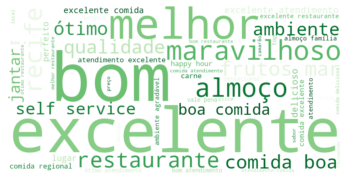

In [52]:
plt.imshow(titles_cloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud1.png')

Great! This wordcloud shows us that the majority of the reviews titles relates to the rating of the restaurant. Being "Good" the title most attributed to the user experience. Then comes "Excellent", "Best", "Wonderful". The other group of titles relates to the type of meal that users were having, like "Lunch" and "Dinner".
It is also possible to creeate a bar plot to show the exact frequency of the words.

In [118]:
# Let's calculate Term Frequency manually
TF = []

for word in set(filtered_titles):
    TF.append(filtered_titles.count(word))
    
terms = list(set(filtered_titles))

As there are a lot of words, lets only use the words with frequency more than 100, for example.

In [126]:
# Creating a dataframe to handle easily the plots
df_tf = pd.DataFrame(np.array([terms, TF]).transpose(), columns=['Term', 'Frequency'])
df_tf.head(10)

,Term,Frequency
0,controlar-se,1
1,oleo,1
2,sopas,1
3,poço,2
4,detalhe,2
5,amarante,2
6,impacientes,1
7,peça,7
8,japonês,10
9,bagaceira,1


In [130]:
df_tf.sort_values(by='Frequency', ascending=False)

,Term,Frequency
2462,cozinha,98
1952,quilo,96
3865,opções,96
443,impecável,95
2587,cardápio,95
...,...,...
2326,qq,1
2327,saleiro,1
2328,frituras,1
2329,pratico,1


In [133]:
max(TF)

3682

In [91]:
top_100_frequencies = [tf for tf in TF if tf > 500]
top_100_terms = []

In [100]:
for j in range(len(terms)):
    if TF[j] > 500:
        top_100_terms.append(terms[j])

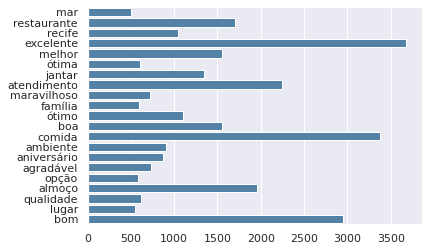

In [99]:
sns.set_theme('notebook')
sns.barplot(y=top_100_terms,
            x=top_100_frequencies,
           color='steelblue')
plt.show()

/home/michel/anaconda3/envs/datascience/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 129368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/michel/anaconda3/envs/datascience/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128079 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/michel/anaconda3/envs/datascience/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 129316 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/michel/anaconda3/envs/datascience/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127995 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/michel/anaconda3/envs/datascience/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127860 missing from current font.
  font.set_text(s, 0.0, flags=fl

/home/michel/anaconda3/envs/datascience/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 129392 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/michel/anaconda3/envs/datascience/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128577 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/michel/anaconda3/envs/datascience/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127881 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/michel/anaconda3/envs/datascience/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128151 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/michel/anaconda3/envs/datascience/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127863 missing from current font.
  font.set_text(s, 0, flags=flags)
/home

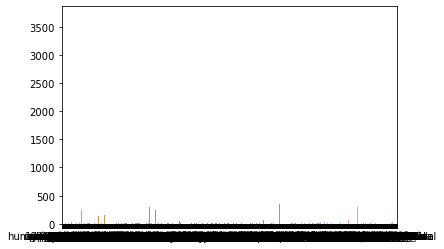